## 0. 모델 고정해서 사용하기

In [1]:
!pip install keras-tuner

     |████████████████████████████████| 129 kB 4.3 MB/s            


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [3]:
# 모델 생성
model = Sequential([
    # 첫 번째 컨볼루션 블록
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    AveragePooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 두 번째 컨볼루션 블록
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 플래튼 레이어
    Flatten(),

    # 완전 연결 레이어
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax') # 출력 클래스가 10개인 경우
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

## 1. Data Centric AI 맛보기

170508288/170498071 [==============================] - 3s 0us/step


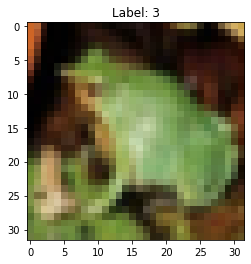

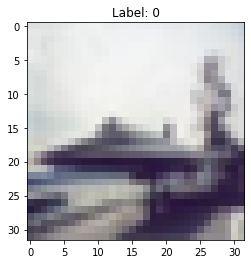

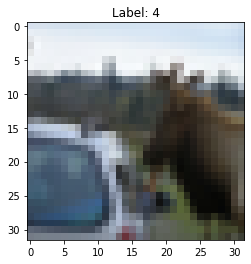

In [4]:
# CIFAR-10 데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# ID 기반 시각화
def visualize_data(ids, images, labels):
    for idx in ids:
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx][0]}")
        plt.show()

# 잘못된 라벨 ID
error_ids = [2405, 6877, 8058]  # labelerrors.com에서 확인한 ID
visualize_data(error_ids, x_test, y_test)

# 라벨 수정
correct_labels = [6, 8, 7]  # 수정할 라벨 값
for i, idx in enumerate(error_ids):
    y_test[idx] = correct_labels[i]

## 2. 하이퍼파라미터 튜닝

In [5]:
# 모델 정의 함수
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu', input_shape=(32, 32, 3)),
        AveragePooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(hp.Int('conv2_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        AveragePooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'),
        Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.5])),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # 시도할 모델의 개수
    executions_per_trial=2,  # 각 하이퍼파라미터 조합별 반복 횟수
    directory='cifar10_tuning',
    project_name='cifar10_project'
)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# 최적의 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"최적 필터 크기 1: {best_hps.get('conv1_filters')}")
print(f"최적 필터 크기 2: {best_hps.get('conv2_filters')}")
print(f"최적 드롭아웃 비율: {best_hps.get('dropout_rate')}")

Trial 10 Complete [00h 02m 57s]
val_accuracy: 0.7188000082969666

Best val_accuracy So Far: 0.7474499940872192
Total elapsed time: 00h 26m 28s
최적 필터 크기 1: 48
최적 필터 크기 2: 32
최적 드롭아웃 비율: 0.5


In [7]:
# 최적 하이퍼파라미터로 모델 생성 및 학습
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# 모델 저장
model.save('cifar10_saved_model.h5')

Epoch 1/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5048 - accuracy: 0.4896 - val_loss: 1.5183 - val_accuracy: 0.5023
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0821 - accuracy: 0.6188 - val_loss: 1.1856 - val_accuracy: 0.5853
Epoch 3/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.9350 - accuracy: 0.6730 - val_loss: 1.1356 - val_accuracy: 0.5970
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8354 - accuracy: 0.7081 - val_loss: 2.2538 - val_accuracy: 0.4215
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7458 - accuracy: 0.7387 - val_loss: 0.8332 - val_accuracy: 0.7157
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6759 - accuracy: 0.7628 - val_loss: 1.0010 - val_accuracy: 0.6526
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6109 - accuracy: 0.7857 - val_loss: 0.9666 - val_accuracy:

## 3. 모델 배포하기 (옵션)

## 4. TFLite 모델 만들기 (옵션)

In [8]:
import tensorflow as tf

# HDF5 파일로 저장된 모델 로드
model = tf.keras.models.load_model('cifar10_saved_model.h5')

# TFLite 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# TFLite 파일 저장
with open('cifar10_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite 모델이 성공적으로 저장되었습니다!")

INFO:tensorflow:Assets written to: /tmp/tmpd2zyylh0/assets
TFLite 모델이 성공적으로 저장되었습니다!


In [9]:
# TFLite 모델 서명 확인
interpreter = tf.lite.Interpreter(model_path='cifar10_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("입력 텐서 정보:", input_details)
print("출력 텐서 정보:", output_details)

입력 텐서 정보: [{'name': 'conv2d_2_input', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
출력 텐서 정보: [{'name': 'Identity', 'index': 25, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
